## Research Paper 1, Experiment 1
### Univariate Time Series forecating using variation of LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

<Axes: xlabel='date'>

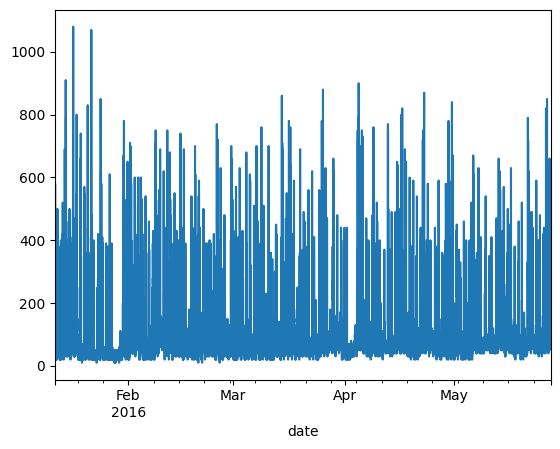

In [3]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date')['Appliances'].plot()

In [4]:
df.shape, df.columns

((19735, 29),
 Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
        'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
        'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
        'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
       dtype='object'))

In [5]:
columns = ['Appliances']

In [6]:
train_df = df[columns].iloc[0:13814,:]
val_df = df[columns].iloc[13814:16774,:]
test_df = df[columns].iloc[16774:,:]

In [10]:
num_features  = len(columns)
input_width = 24
label_width = 1
OUT_STEPS = 1
shift = 1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['Appliances']

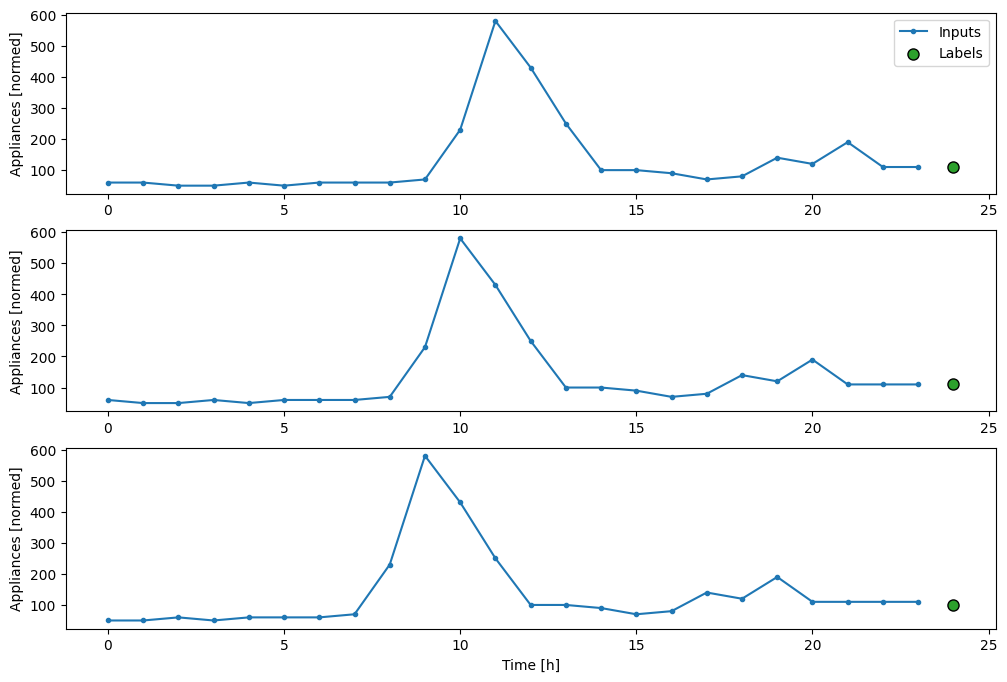

In [13]:
from WindowGenerator import WindowGenerator

single_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=1,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_columns=['Appliances'])

single_window.plot()
single_window

In [9]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [12]:
train_performance = {}
val_performance = {}
test_performance = {}

## Model 1: Base LSTM

In [14]:

single_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(single_lstm_model, single_window)

#IPython.display.clear_output()


Epoch 1/20
431/431 [==============================] - 11s 17ms/step - loss: 15534.2490 - mean_squared_error: 15534.2490 - val_loss: 8106.7119 - val_mean_squared_error: 8106.7119
Epoch 2/20
431/431 [==============================] - 9s 20ms/step - loss: 9617.3281 - mean_squared_error: 9617.3281 - val_loss: 5691.5186 - val_mean_squared_error: 5691.5186
Epoch 3/20
431/431 [==============================] - 9s 22ms/step - loss: 7102.8394 - mean_squared_error: 7102.8394 - val_loss: 4513.7314 - val_mean_squared_error: 4513.7314
Epoch 4/20
431/431 [==============================] - 7s 17ms/step - loss: 5820.5034 - mean_squared_error: 5820.5034 - val_loss: 3919.7087 - val_mean_squared_error: 3919.7087
Epoch 5/20
431/431 [==============================] - 8s 19ms/step - loss: 5232.6978 - mean_squared_error: 5232.6978 - val_loss: 3675.3003 - val_mean_squared_error: 3675.3003
Epoch 6/20
431/431 [==============================] - 11s 25ms/step - loss: 5016.9961 - mean_squared_error: 5016.9961 - va

In [15]:
train_performance['LSTM'] = single_lstm_model.evaluate(single_window.val)
val_performance['LSTM'] = single_lstm_model.evaluate(single_window.val)
test_performance['LSTM'] = single_lstm_model.evaluate(single_window.test)

92/92 [==============================] - 1s 7ms/step - loss: 3808.5576 - mean_squared_error: 3808.5576


In [21]:
test_performance

{'LSTM': [3808.5576171875, 3808.5576171875]}

In [ ]:
!pip install sktime
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [22]:
def evaluate_model(predictions, actuals):
  rmse = tf.keras.metrics.RootMeanSquaredError(predictions,actuals)
  mae  = tf.keras.metrics.MeanAbsoluteError(predictions,actuals)
  mase = mean_absolute_scaled_error(actuals, predictions, y_train=y_train1)
  return evalutation